## **Importacion de las librerias y datos**

---


In [ ]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

# Data analysis imports
import pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('darkgrid')
colors = sns.color_palette('pastel')
sns.set_palette(['#ff9999','#66b3ff','#99ff99','#ffcc99','#ff66b3'])
%matplotlib inline

# Machine learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [ ]:
# Data extraida de kaggle
df = pd.read_csv('https://raw.githubusercontent.com/Xukay101/curso-data-science/main/datasets/heart.csv')

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## **Data Cleaning**

___

In [ ]:
# Analisis de valores nulos
print(f'Valores nulos: {df.isna().sum()}')
# Tratamiento de valores nulos
df.fillna(df.mean())

Valores nulos: age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


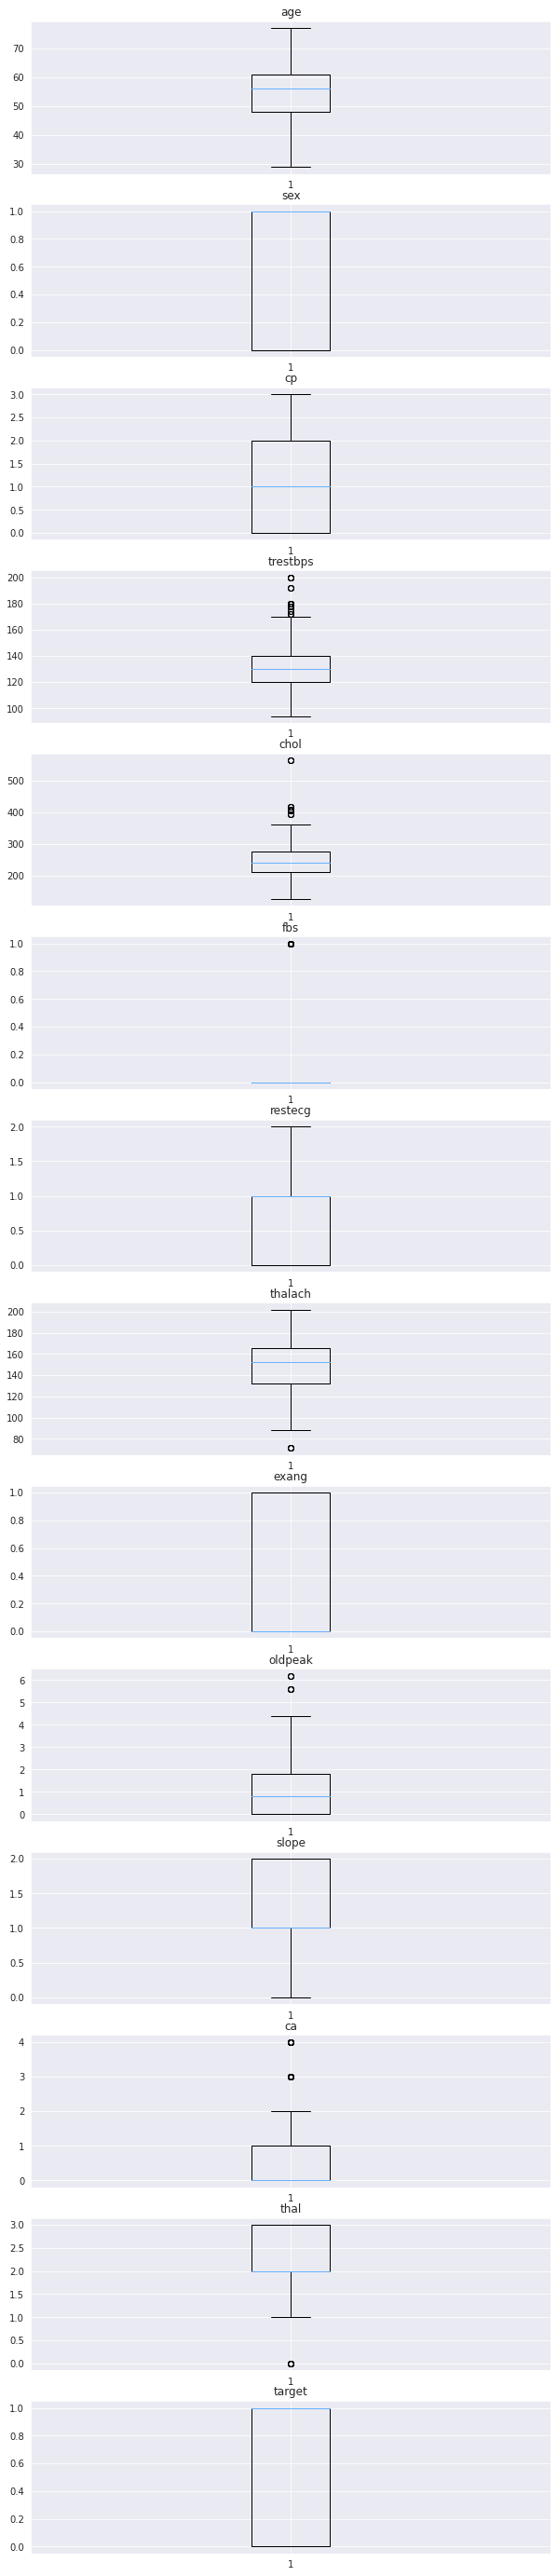

In [ ]:
# Analisis de outliers
fig, axs = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10,50))
for i, column in enumerate(df.columns):
    axs[i].boxplot(df[column])
    axs[i].set_title(column)

In [ ]:
# Rango intercuartilico para cada columna
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Eliminacion de valores fuera del rango
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f'Cantidad de filas: {df_out.shape[0]}')

Cantidad de filas: 769


Otro paso importante sería la limpieza de datos, es decir, detectar y tratar valores faltantes o outliers.

Además, también se podría realizar un análisis estadístico para conocer la distribución de las características y detectar posibles sesgos en los datos.

En resumen, el siguiente paso en el EDA sería analizar las relaciones entre las características, limpiar los datos y analizar las distribuciones de las características.

## **Modelado**

___

### Encoding

In [ ]:
df = pd.get_dummies(df, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])

### Feature Engineering

In [ ]:
# Creacion de nuevas variables

df['ratio_trestbps_chol'] = df['trestbps'] / df['chol'] # relacion entre la variable 'trestbps' y la variable 'chol'
df['prod_thalach_oldpeak'] = df['thalach'] * df['oldpeak'] # producto entre la variable 'thalach' y la variable 'oldpeak'
df['prod_age_chol'] = df['age'] * df['chol'] # Producto entre la variable 'age' y 'chol'

In [ ]:
# Matriz de correlación entre las nuevas variables y la variable objetivo 'target'
corr_matrix = df[['prod_age_chol', 'prod_thalach_oldpeak', 'ratio_trestbps_chol', 'target']].corr()

corr_matrix

,prod_age_chol,prod_thalach_oldpeak,ratio_trestbps_chol,target
prod_age_chol,1.000000,0.132988,-0.568915,-0.186717
prod_thalach_oldpeak,0.132988,1.000000,0.077594,-0.388866
ratio_trestbps_chol,-0.568915,0.077594,1.000000,0.017532
target,-0.186717,-0.388866,0.017532,1.000000


### Machine Learning

___

In [ ]:
# Modelo de regresion logistica
model = LogisticRegression()

# Selección de características
sfs = SFS(model, 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5)

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

# Conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Estandarización de los datos
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

scaler = preprocessing.StandardScaler().fit(X_test)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# Obtencion de las mejores características
sfs.fit(X_train_scaled, y_train)

best_features = X_train_scaled.columns[list(sfs.k_feature_idx_)]

best_features

Index(['trestbps', 'oldpeak', 'cp_0', 'slope_0', 'slope_2', 'ca_0', 'ca_3',
       'ca_4', 'thal_2', 'prod_thalach_oldpeak'],
      dtype='object')

In [ ]:
# Entrenamiento y predicciones
model.fit(X_train_scaled[best_features], y_train)
y_pred = model.predict(X_test_scaled[best_features])

In [ ]:
# Metricas
acc = accuracy_score(y_test, y_pred) # accuracy
print("Accuracy:", acc)

Accuracy: 0.8341463414634146


In [ ]:
# Validación cruzada con 5 particiones
scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Metricas
print("Puntuaciones de validación cruzada: ", scores)

Puntuaciones de validación cruzada:  [0.84146341 0.8902439  0.8902439  0.85365854 0.91463415 0.87804878
 0.92682927 0.8902439  0.85365854 0.7804878 ]


Se pueden notar puntajes mas altos en su mayoria ya que la validación cruzada permite entrenar y evaluar el modelo varias veces, utilizando diferentes divisiones de los datos en conjunto de entrenamiento y conjunto de prueba.